# Testing Notebook

### Description

This notebook is for testing to see what models work best with our TinderBCI.

In [5]:
%matplotlib inline

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(42)

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# PCA
from sklearn.decomposition import PCA

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score

#not sure
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#exporting
from sklearn.externals import joblib

from collections import Counter
from mpl_toolkits import mplot3d

# Preprocessing & EDA

In [2]:
# Read in the data
EEG_data = pd.read_csv("./data/output-2.csv", sep=",", header=None)
EEG_data.columns = ['rawValue', 'attention', 'meditation', 'delta', 'theta', 
                    'lowAlpha', 'highAlpha', 'lowBeta', 'highBeta', 'lowGamma', 
                    'midGamma', 'std_rawValue', 'std_attention', 'std_meditation', 
                    'std_delta', 'std_theta', 'std_lowAlpha', 'std_highAlpha', 
                    'std_lowBeta', 'std_highBeta', 'std_lowGamma', 'std_midGamma', 'choice']

EEG_data = EEG_data[EEG_data['meditation'] != 0] #removing datapoints with faulty readings
EEG_data.describe()

,rawValue,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,...,std_attention,std_meditation,std_delta,std_theta,std_lowAlpha,std_highAlpha,std_lowBeta,std_highBeta,std_lowGamma,std_midGamma
count,371.000000,371.000000,371.000000,3.710000e+02,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,...,371.000000,371.000000,3.710000e+02,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,52.690404,53.431344,57.238168,2.282175e+05,57730.951783,16655.858846,12967.897573,11150.665868,8324.540210,4363.173829,...,6.522292,6.017082,1.989776e+05,43625.595961,11917.403847,9060.379270,7432.154523,4673.926704,2410.037498,1891.791374
std,19.923842,14.053264,11.887176,3.094555e+05,65438.907078,13604.363444,10706.944114,12852.340347,6609.856823,3768.380037,...,3.596943,2.971311,2.549638e+05,65725.665111,13156.448940,11555.841794,16553.676330,9121.799202,3834.244482,2630.194997
min,12.433953,6.900516,22.054937,7.714987e+03,8099.737305,2126.143555,1888.265625,1477.376343,1569.266357,618.973083,...,0.795036,0.474547,1.645218e+03,1561.984375,279.979309,340.253387,283.248810,276.286316,83.995743,102.377998
25%,41.609287,43.586803,49.201145,3.022657e+04,21566.484375,8366.832031,6611.811035,5636.291992,5067.736328,2423.704590,...,3.967126,4.052960,1.778492e+04,9024.436523,4181.635986,3218.788208,2086.109253,1447.198608,790.791290,583.422577
50%,43.841564,53.681458,57.379589,8.240791e+04,34974.304688,12907.627930,9675.630859,7620.844238,6492.234863,3294.285400,...,5.973560,5.542127,7.518289e+04,20045.433594,7370.278809,5372.085938,3667.779785,2675.522217,1293.169556,971.464355
75%,55.150244,62.063541,65.640541,2.779564e+05,70436.117188,20387.119141,15355.339844,11688.361816,9296.742676,4900.012451,...,8.359354,7.743251,2.720562e+05,46774.718750,15261.222656,9557.183594,6956.078613,4849.743164,2329.502686,2041.725098
max,140.301910,95.216919,93.873352,1.959751e+06,683362.437500,115541.679688,83999.078125,167301.906250,70132.828125,34876.558594,...,20.157749,16.155012,1.303613e+06,644252.625000,90238.992188,83905.117188,270780.625000,127406.531250,40988.765625,20975.603516


In [3]:
# Extracting the label data
y_labels = EEG_data.pop('choice').values
# Getting colors for the plots
y_labels_plot = ['r' if c =='right' else 'b' for c in y_labels]

# Encode the labels for the classifiers
le = LabelEncoder()
encoded_labels = le.fit_transform(y_labels)

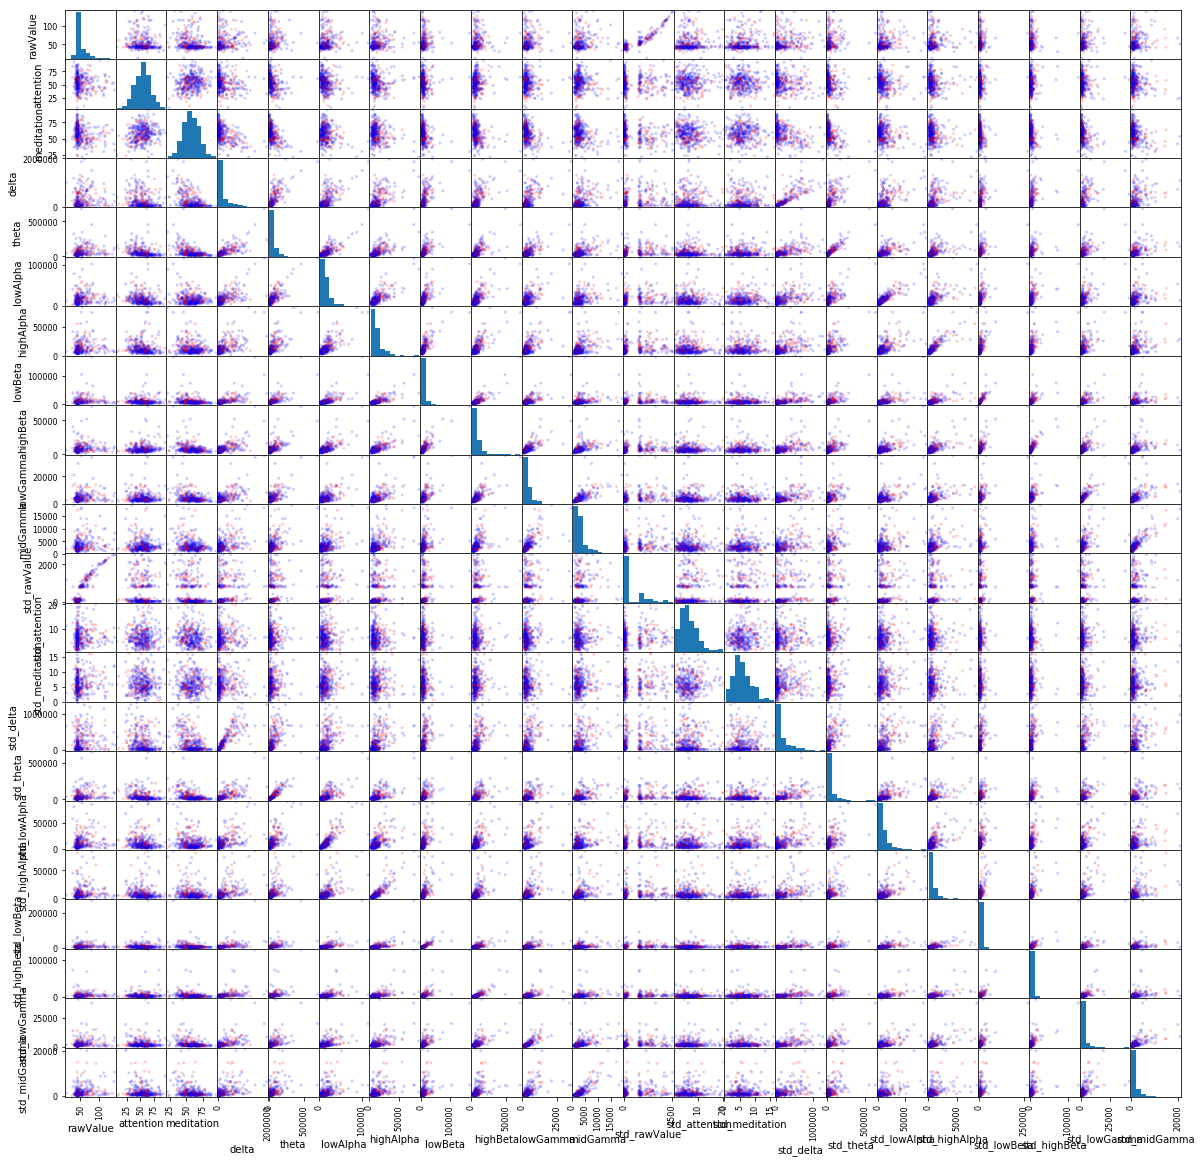

In [6]:
fig = pd.plotting.scatter_matrix(EEG_data, alpha=0.2, figsize=(20,20), c=y_labels_plot)
plt.show()

In the graph above, we see a lot of the variables correlate with each other. However, It seems like the data is non-sperable

## Splitting the data

Looking at the dataset, we notice that our subject chose to swipe one way more than the other (about 3 left swipes to 1 right swipe). As a result of this, our classifier was always predicting a left swipe and getting arounda 75% accuracy. To counter that, we split our training data to be 50-50.

In [81]:
# Choosing training size
train_size = 50

df_right = EEG_data[encoded==1]
df_left = EEG_data[encoded==0]

# Getting the indices for the right and left swipe datapoints
right_ind = random.sample(list(range(len(df_right))), train_size)
left_ind = random.sample(list(range(len(df_left))), train_size)

In [84]:
# Setting up the train/test split
train_ind = list(df_right.index[right_ind])+list(df_left.index[left_ind])
mask = np.ones(len(EEG_data), bool)
mask[train_ind] = False

X_train = EEG_data.iloc[train_ind]
y_train = encoded_labels[train_ind]

X_test = EEG_data[mask]
y_test = encoded_labels[mask]

# Shuffling the training data
c = list(zip(X_train.values, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)
X_train = list(X_train)
y_train = list(y_train)

In [ ]:
# Some of the data has very large numbers so we will use a scaler. Since some of the data is not normally distributed we chose
# a MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Classification

## RandomForestClassifier

In [88]:
depth = 3

clf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)

print 'Max_Depth', depth
print 'Training Accuracy', accuracy_score(y_train_pred, y_train)
print f1_score(y_train_pred, y_train)
print precision_score(y_train_pred, y_train)

y_test_pred = clf.predict(X_test_scaled)
print 'Testing Metrics', accuracy_score(y_test_pred, y_test)
print f1_score(y_test_pred,y_test)
print precision_score(y_test_pred, y_test)

Max_Depth 3
Training Accuracy 0.9
0.9038461538461539
0.94
Testing Metrics 0.6051660516605166
0.3954802259887006
0.7142857142857143


## SVM

In [ ]:
param_grid = [{'loss': ['hinge', 'squared_hinge']}]
svc_clf = LinearSVC()
grid_search = GridSearchCV(svc_clf,param_grid,cv=2,n_jobs=-1,scoring='f1')
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_, "\n", grid_search.best_estimator_)
y_train_pred = grid_search.best_estimator_.predict(X_train_scaled)

print 'Training Accuracy:', accuracy_score(y_pred=y_train_pred, y_true=y_train)
print 'Training f1_score:', f1_score(y_pred=y_train_pred, y_true=y_train)
print 'Training Precision Score:', precision_score(y_pred=y_train_pred, y_true=y_train)

y_test_pred = grid_search.best_estimator_.predict(X_test_scaled)
print 'Testing Metrics:', accuracy_score(y_pred=y_test_pred, y_true=y_test)
print 'Testing f1_score:', f1_score(y_pred=y_test_pred, y_true=y_test)
print 'Testing Precision Score:', precision_score(y_pred=y_test_pred, y_true=y_test)

## LDA

In [110]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)

print 'Training Accuracy', accuracy_score(y_train_pred, y_train)
print f1_score(y_train_pred, y_train)
print precision_score(y_train_pred, y_train)

y_test_pred = clf.predict(X_test_scaled)
print 'Testing Metrics', accuracy_score(y_test_pred, y_test)
print f1_score(y_test_pred,y_test)
print precision_score(y_test_pred, y_test)

Training Accuracy 0.69
0.686868686868687
0.68
Testing Metrics 0.5498154981549815
0.3440860215053763
0.6530612244897959


## Saving models

In [45]:
#to export a model:
joblib.dump(clf,'randForestClass_py2.pkl')

joblib.dump(scaler,'scaler_py2.pkl')

#to import a model:
#clf = joblib.load('<nameofmodel>.pkl')

['scaler_py2.pkl']